# Text Classification Guide
## IMDB Movie Reviews Dataset
Let's start by analyzing our dataset and making some plots

In [1]:
from util import explore, vectorize, models, imdb
import train as training
import matplotlib.pyplot as plt

In [2]:
train, val = imdb.load_imdb()
X, y = train

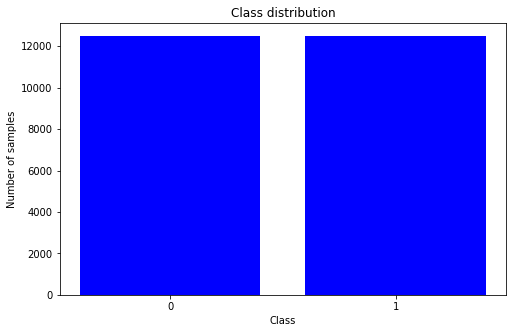

In [3]:
plt.figure(figsize=(8, 5))
explore.plot_class_dist(y)

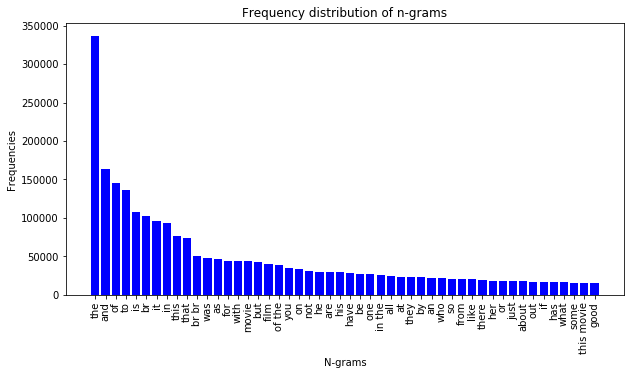

In [4]:
plt.figure(figsize=(10, 5))
explore.plot_freq_dist(X)

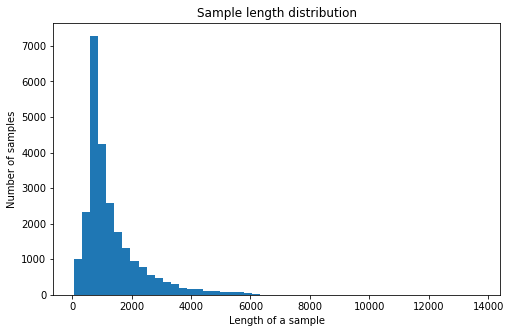

In [5]:
plt.figure(figsize=(8, 5))
explore.plot_length_dist(X)

## Choose Model

At this point, we have assembled our dataset and gained insights into the key characteristics of our data. Based on the metrics we gathered, we should think about which classification model we should use.

In the flowchart below, the yellow boxes indicate data and model preparation processes. Grey boxes and green boxes indicate choices considered for each process. Green boxes indicate recommended choice for each process.

We can use this flowchart as a starting point to construct our model, as it will give you good accuracy at low computation costs.

<img src='https://res.cloudinary.com/dpyleb8ih/image/upload/v1555860048/TextClassificationFlowchart.png' >

Models can be broadly classified into two categories: 
- Those that use word ordering information (sequence models)
- Others that just see text as “bags” (sets) of words (n-gram models). 

Types of sequence models include convolutional neural networks (CNNs), recurrent neural networks (RNNs), and their variations. Types of n-gram models include logistic regression, simple multi- layer perceptrons (MLPs, or fully-connected neural networks), gradient boosted trees and support vector machines.

**Which learning algorithm or model should we use?**

**How should we prepare the data to efficiently learn the relationship between text and label?**

The ratio of “number of samples” (S) to “number of words per sample” (W) correlates with which model performs well.

When the value for this ratio is small (<1500), small multi-layer perceptrons that take n-grams as input perform better or at least as well as sequence models. MLPs are simple to define and understand, and they take much less compute time than sequence models. When the value for this ratio is large (>= 1500), use a sequence model.

In [6]:
sw = len(X) / explore.get_num_words(X)   # samples/words-per-sample
print(sw)

143.67816091954023


In the case of our IMDb review dataset, the samples/words-per-sample ratio is ~144. This means that we will create a MLP model.

## Prepare the Data

Before our data can be fed to a model, it needs to be transformed to a format the model can understand. We will need to convert the texts into numerical vectors. There are two steps to this process:

- **Tokenization**: Divide the texts into words or smaller sub-texts, which will enable good generalization of relationship between the texts and the labels. This determines the “vocabulary” of the dataset (set of unique tokens present in the data).


- **Vectorization**: Define a good numerical measure to characterize these texts.

Let’s see how to perform these two steps for both n-gram vectors and sequence vectors, as well as how to optimize the vector representations using feature selection.

### N-gram vectors

In an n-gram vector, text is represented as a collection of unique n-grams: groups of n adjacent tokens (typically, words). Consider the text The mouse ran up the clock. Here, the word unigrams (n = 1) are `['the', 'mouse', 'ran', 'up', 'clock']`, the word bigrams (n = 2) are `['the mouse', 'mouse ran', 'ran up', 'up the', 'the clock']`, and so on. With n-gram vector representation, we discard a lot of information about word order and grammar (at best, we can maintain some partial ordering information when n > 1). This is called a bag-of-words approach. This representation is used in conjunction with models that don’t take ordering into account, such as logistic regression, multi-layer perceptrons, gradient boosting machines, support vector machines.

**Tokenization**

Tokenizing into word unigrams + bigrams provides good accuracy while taking less compute time.

**Vectorization**

Once we have split our text samples into n-grams, we need to turn these n-grams into numerical vectors. Let's see a sample for unigrams and bigrams generated for two texts.
```
Texts: 'The mouse ran up the clock' and 'The mouse ran down'
Index assigned for every token: {'the': 7, 'mouse': 2, 'ran': 4, 'up': 10, 'clock': 0, 'the mouse': 9, 'mouse ran': 3, 'ran up': 6, 'up the': 11, 'the clock': 8, 'down': 1, 'ran down': 5}
```
Once indexes are assigned to the n-grams, we typically vectorize using one of the following options.

- One-hot encoding: Every sample text is represented as a vector indicating the presence or absence of a token in the text. `'The mouse ran up the clock' = [1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]`

- Count encoding: Every sample text is represented as a vector indicating the count of a token in the text. Note that the element corresponding to the unigram 'the' (bolded below) now is represented as 2 because the word “the” appears twice in the text. `'The mouse ran up the clock' = [1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1]`

- Tf-idf encoding: The problem with the above two approaches is that common words that occur in similar frequencies in all documents (i.e., words that are not particularly unique to the text samples in the dataset) are not penalized. For example, words like “a” will occur very frequently in all texts. So a higher token count for “the” than for other more meaningful words is not very useful. `'The mouse ran up the clock' = [0.33, 0, 0.23, 0.23, 0.23, 0, 0.33, 0.47, 0.33, 0.23, 0.33, 0.33]`


Tf-idf encoding is marginally better than the other two in terms of accuracy (on average: 0.25-15% higher), and recommend using this method for vectorizing n-grams. However, keep in mind that it occupies more memory (as it uses floating-point representation) and takes more time to compute, especially for large datasets.

**Feature selection**

When we convert all of the texts in a dataset into word uni+bigram tokens, we may end up with tens of thousands of tokens. Not all of these tokens/features contribute to label prediction. So we can drop certain tokens, for instance those that occur extremely rarely across the dataset. We can also measure feature importance (how much each token contributes to label predictions), and only include the most informative tokens.

There are many statistical functions that take features and the corresponding labels and output the feature importance score. Two commonly used functions are f_classif and chi2. 

In [7]:
acc, loss = training.train_ngram(train, val)

W0629 18:00:55.929214 140239932491584 deprecation.py:506] From /home/fazil/anaconda3/envs/tf_env/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0629 18:00:56.050505 140239932491584 deprecation.py:323] From /home/fazil/anaconda3/envs/tf_env/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 25000 samples, validate on 25000 samples
Epoch 1/1000
25000/25000 [==============================] - 15s 618us/sample - loss: 0.4656 - acc: 0.8706 - val_loss: 0.3198 - val_acc: 0.8879
Epoch 2/1000
25000/25000 [==============================] - 15s 581us/sample - loss: 0.2316 - acc: 0.9223 - val_loss: 0.2502 - val_acc: 0.9032
Epoch 3/1000
25000/25000 [==============================] - 15s 581us/sample - loss: 0.1673 - acc: 0.9414 - val_loss: 0.2333 - val_acc: 0.9068
Epoch 4/1000
25000/25000 [==============================] - 15s 596us/sample - loss: 0.1342 - acc: 0.9528 - val_loss: 0.2303 - val_acc: 0.9062
Epoch 5/1000
25000/25000 [==============================] - 15s 593us/sample - loss: 0.1098 - acc: 0.9647 - val_loss: 0.2345 - val_acc: 0.9038
Epoch 6/1000
25000/25000 [==============================] - 15s 596us/sample - loss: 0.0941 - acc: 0.9699 - val_loss: 0.2399 - val_acc: 0.9026


In [8]:
print('Final ACC: {} Final Loss: {}'.format(acc, loss))

Final ACC: 0.9025999903678894 Final Loss: 0.23994816658496856
